In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import torch

## Data Cleaning & Preprocessing

In [81]:
# Load the data into a DataFrame
dateformat_str = "%Y-%m-%d %H:%M"
data = pd.read_csv('data/tsla_2019_2022.csv', na_values=[' '], skipinitialspace=True, date_format=dateformat_str, parse_dates=True) # some missing values in the dataset are given as an empty space

# Remove leading and trailing whitespace and square brackets from column names
data.columns = data.columns.str.strip('data.columns.str.strip(" []")')

# Display the column names
print("Column names:", data.columns)

print("Shape of data:", data.shape)

Column names: Index(['QUOTE_UNIXTIME', 'QUOTE_READTIME', 'QUOTE_DATE', 'QUOTE_TIME_HOURS',
       'UNDERLYING_LAST', 'EXPIRE_DATE', 'EXPIRE_UNIX', 'DTE', 'C_DELTA',
       'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO', 'C_IV', 'C_VOLUME', 'C_LAST',
       'C_SIZE', 'C_BID', 'C_ASK', 'STRIKE', 'P_BID', 'P_ASK', 'P_SIZE',
       'P_LAST', 'P_DELTA', 'P_GAMMA', 'P_VEGA', 'P_THETA', 'P_RHO', 'P_IV',
       'P_VOLUME', 'STRIKE_DISTANCE', 'STRIKE_DISTANCE_PCT'],
      dtype='object')
Shape of data: (2659259, 33)


In [82]:
# Convert cols with date/time to datetime data type
data["QUOTE_READTIME"] = pd.to_datetime(data["QUOTE_READTIME"], format="%Y-%m-%d %H:%M", exact=True)
data["QUOTE_DATE"] = pd.to_datetime(data["QUOTE_DATE"], format="%Y-%m-%d", exact=True)
data["EXPIRE_DATE"] = pd.to_datetime(data["EXPIRE_DATE"], format="%Y-%m-%d", exact=True)
# can use .dt.tz_localize(tz="US/Eastern") to set to Eastern time then convert to local timezone if we want to
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2659259 entries, 0 to 2659258
Data columns (total 33 columns):
 #   Column               Dtype         
---  ------               -----         
 0   QUOTE_UNIXTIME       int64         
 1   QUOTE_READTIME       datetime64[ns]
 2   QUOTE_DATE           datetime64[ns]
 3   QUOTE_TIME_HOURS     float64       
 4   UNDERLYING_LAST      float64       
 5   EXPIRE_DATE          datetime64[ns]
 6   EXPIRE_UNIX          int64         
 7   DTE                  float64       
 8   C_DELTA              float64       
 9   C_GAMMA              float64       
 10  C_VEGA               float64       
 11  C_THETA              float64       
 12  C_RHO                float64       
 13  C_IV                 float64       
 14  C_VOLUME             float64       
 15  C_LAST               float64       
 16  C_SIZE               object        
 17  C_BID                float64       
 18  C_ASK                float64       
 19  STRIKE               

In [83]:
print(data[data.isnull().any(axis=1)].shape)
# 897680/2659259 = 0.337 of rows have some missing value in some cols, so we shouldn't drop them since its a large portion of the dataset

(897680, 33)


In [84]:
# Display the first few rows of the DataFrame to ensure it loaded correctly
data.head()

,QUOTE_UNIXTIME,QUOTE_READTIME,QUOTE_DATE,QUOTE_TIME_HOURS,UNDERLYING_LAST,EXPIRE_DATE,EXPIRE_UNIX,DTE,C_DELTA,C_GAMMA,...,P_LAST,P_DELTA,P_GAMMA,P_VEGA,P_THETA,P_RHO,P_IV,P_VOLUME,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT
0,1556740800,2019-05-01 16:00:00,2019-05-01,16.0,233.98,2019-05-03,1556913600,2.0,0.98465,0.00055,...,0.01,-0.00071,0.00003,0.00046,-0.00975,0.00000,2.22548,147.0,104.0,0.444
1,1556740800,2019-05-01 16:00:00,2019-05-01,16.0,233.98,2019-05-03,1556913600,2.0,0.98371,0.00067,...,0.02,-0.00109,0.00009,0.00058,-0.01010,-0.00001,2.08349,12.0,99.0,0.423
2,1556740800,2019-05-01 16:00:00,2019-05-01,16.0,233.98,2019-05-03,1556913600,2.0,0.98458,0.00069,...,0.02,-0.00122,0.00012,0.00113,-0.01435,0.00000,2.02359,15.0,94.0,0.402
3,1556740800,2019-05-01 16:00:00,2019-05-01,16.0,233.98,2019-05-03,1556913600,2.0,0.99187,0.00049,...,0.01,-0.00134,0.00009,0.00139,-0.01465,0.00000,1.89504,0.0,89.0,0.380
4,1556740800,2019-05-01 16:00:00,2019-05-01,16.0,233.98,2019-05-03,1556913600,2.0,0.99341,0.00039,...,0.01,-0.00176,0.00008,0.00105,-0.01467,0.00000,1.76812,91.0,84.0,0.359


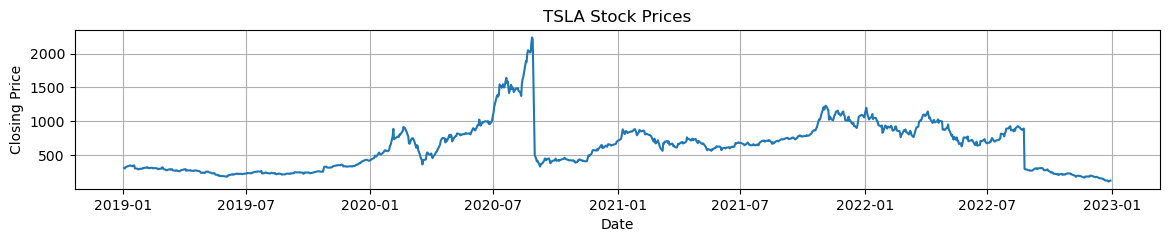

In [85]:
agg_underlying = data.groupby('QUOTE_DATE', as_index=False).agg({
    'UNDERLYING_LAST': ['mean', 'min', 'max']
})

plt.figure(figsize=(14, 7))
# Plotting Log Returns
plt.subplot(3, 1, 1)
plt.plot(agg_underlying['QUOTE_DATE'], agg_underlying['UNDERLYING_LAST']['max'], label='Underlying Close Price')
plt.title('TSLA Stock Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)

[*********************100%%**********************]  1 of 1 completed

Data retrieved successfully.


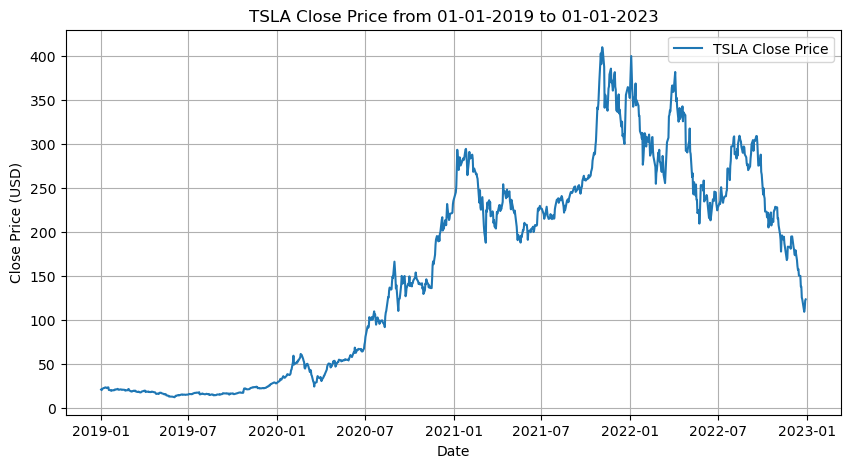

In [86]:
# compare these prices to yfinance's close prices  for the same interval
import yfinance as yf

# Define the ticker symbol and the time period
ticker = "TSLA"
start_date = "2019-01-01"
end_date = "2023-01-01"

# Fetch the historical data
data = yf.download(ticker, start=start_date, end=end_date)

# Check if data was retrieved (optional)
if data.empty:
    print("No data retrieved. Check your ticker symbol or date range.")
else:
    print("Data retrieved successfully.")
    
# Plotting the closing prices
plt.figure(figsize=(10, 5))
plt.plot(data['Close'], label='TSLA Close Price')
plt.title('TSLA Close Price from 01-01-2019 to 01-01-2023')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

### Realized Volatility

We need to calculate realized/historical volatility as that is the real volatility we want to predict. Implied volatility is calculated through solving for volatility using options price and other inputs at a given time using Black-Scholes and other models.

In [87]:
# extract underlying price for each day
underlying = data[['QUOTE_DATE', 'UNDERLYING_LAST']]
underlying = underlying.drop_duplicates(subset=['QUOTE_DATE'])

# Verify there is only one price per date
if underlying['QUOTE_DATE'].duplicated().any():
    print("Warning: There are multiple prices for at least one date.")
else:
    print("Each date has a unique price.")

# Check if the DataFrame is sorted by 'QUOTE_DATE'
if underlying['QUOTE_DATE'].is_monotonic_increasing:
    print("The DataFrame is sorted by date.")
else:
    # underlying['Prev_QUOTE_DATE'] = underlying['QUOTE_DATE'].shift(1)
    # unsorted_rows = underlying[underlying['QUOTE_DATE'] < underlying['Prev_QUOTE_DATE']]
    # print("Adjacent rows that are not sorted:")
    # print(unsorted_rows[['Prev_QUOTE_DATE', 'QUOTE_DATE']])
    print("The DataFrame is not sorted by date. Sorting now.")
    underlying = underlying.sort_values(by='QUOTE_DATE')



# calculate log returns and realized volatility of the underlying
window_size = 10  # trading days in rolling window
dpy = 252  # trading days per year
ann_factor = dpy / window_size
# https://stackoverflow.com/questions/43284304/how-to-compute-volatility-standard-deviation-in-rolling-window-in-pandas
underlying['LOG_RETURNS'] = np.log(underlying['UNDERLYING_LAST']) - np.log(underlying['UNDERLYING_LAST'].shift(1))
underlying['REALIZED_VOL'] = np.sqrt(underlying['LOG_RETURNS'].rolling(window=window_size).var() * ann_factor)

KeyError: "None of [Index(['QUOTE_DATE', 'UNDERLYING_LAST'], dtype='object')] are in the [columns]"

In [ ]:
print(underlying['REALIZED_VOL'].unique())
underlying.dropna(inplace=True)

In [ ]:
underlying.shape

In [ ]:
last_n_days = 1000

plt.figure(figsize=(14, 7))
# Plotting Log Returns
plt.subplot(3, 1, 1)
plt.plot(underlying['QUOTE_DATE'][-last_n_days:], underlying['UNDERLYING_LAST'][-last_n_days:], label='Underlying Close Price')
plt.title('TSLA Stock Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)

# Plotting Log Returns
plt.subplot(3, 1, 2)
plt.plot(underlying['QUOTE_DATE'][-last_n_days:], underlying['LOG_RETURNS'][-last_n_days:], label='Log Returns')
plt.title('Daily Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.grid(True)

# Plotting Realized Volatility
plt.subplot(3, 1, 3)
plt.plot(underlying['QUOTE_DATE'][-last_n_days:], underlying['REALIZED_VOL'][-last_n_days:], label='Realized Volatility', color='red')
plt.title('Realized Volatility (10-day window)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Assuming 'df' is your DataFrame and you're checking for outliers in a column named 'column_name'
Q1 = underlying['LOG_RETURNS'].quantile(0.25)
Q3 = underlying['LOG_RETURNS'].quantile(0.75)
IQR = Q3 - Q1

# Define limits for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Finding outliers
outliers = underlying[(underlying['LOG_RETURNS'] < lower_bound) | (underlying['LOG_RETURNS'] > upper_bound)]
outliers

In [ ]:
underlying[('2020-08-01' < underlying['QUOTE_DATE']) & (underlying['QUOTE_DATE'] < '2020-10-01')]

In [ ]:
# Join the 'log_returns' and 'realized_vol' columns back with the full options dataframe
data = pd.merge(data, underlying[['QUOTE_DATE', 'LOG_RETURNS', 'REALIZED_VOL']], on='QUOTE_DATE', how='left')
data['PREV_REALIZED_VOL'] = data['REALIZED_VOL'].shift(1)
data.head()

In [ ]:
data[data['PREV_REALIZED_VOL'] != data['REALIZED_VOL']]

In [ ]:
print(data[data['PREV_REALIZED_VOL'].isna() | data['REALIZED_VOL'].isna() | data['LOG_RETURNS'].isna()].shape)
data = data.dropna(subset=['REALIZED_VOL', 'LOG_RETURNS', 'PREV_REALIZED_VOL'])
print(data[data['PREV_REALIZED_VOL'].isna() | data['REALIZED_VOL'].isna() | data['LOG_RETURNS'].isna()].shape)
print(data.shape)

In [ ]:
vol_df = data.groupby('QUOTE_DATE', as_index=False).agg({
    'REALIZED_VOL': ['mean'],
})

In [ ]:
vol_df.info()

In [ ]:
data['C_MID'] = (data['C_BID'] + data['C_ASK']) / 2
data['P_MID'] = (data['P_BID'] + data['P_ASK']) / 2
data.head()

In [ ]:
data['REALIZED_VOL'].unique()

In [ ]:
underlying.shape # total unique dates

In [ ]:
date_counts = data.groupby('QUOTE_DATE').size()

# Print the result to verify
print(date_counts) # check if all dates have the same row count => they don't

Now, I want to parse for ATM strikes. To do this, I will only be looking at options where the delta is between 45-55, or -45 to -55.

In [ ]:
# Filter data to include only ATM options (where delta is closest to 0.5)
# Ensure column names match exactly what's in the DataFrame
atm_options = data[(data['C_DELTA'] >= 0.45) & (data['C_DELTA'] <= 0.55) & (data['P_DELTA'] >= -0.55) & (data['P_DELTA'] <= -0.45)]

# Display the first few rows of the filtered DataFrame
print("Number of rows in atm_options:", len(atm_options))
print(atm_options.head())
print(atm_options.tail())

In [ ]:
# Check for other missing values or zero values (zero isn't necessarily bad, but missing values for sure are)
zero_count = (atm_options == 0).sum() / atm_options.shape[0]
missing_count = atm_options.isna().sum() / atm_options.shape[0]

print(f"Number of zero values per feature: {zero_count}")
print(f"Number of missing values per feature: {missing_count}")

Zero values shouldn't be a concern, but missing values are.

We can drop rows with missing values if we choose to select them as inputs, otherwise just ignore them because we will only select relevant columns anyways.

Note that for since we only want to predict realized volatility, we don't need to do anything with the validation and test data frame due to them already being complete (dropped missing values already, and those DFs only have two columns).

In [ ]:
atm_options.info()

In [ ]:
# FEATURE SELECTION
# XXX: can't have multiple rows in one date because LSTM doesn't know what a "date" is and uses timesteps to keep track of "dates" instead, so either we need to transform all the different strike prices and DTE for each date into columns, or need to aggregate them somehow; right now I will just aggregate or remove them altogether
# TODO: try different features or ways to increase data given to the model
selected_features = ['QUOTE_UNIXTIME', 'REALIZED_VOL', 'LOG_RETURNS', 'STRIKE', 'C_MID', 'PREV_REALIZED_VOL', 'C_IV', 'P_IV', 'P_MID'] # use QUOTE_UNIXTIME instead of QUOTE_DATE for ML to be able to parse
selected_data = atm_options[selected_features]
print(f"selected_data shape pre-aggregation: {selected_data.shape[0]}")

# Engineering features to summarize multiple entries per date
selected_data = selected_data.groupby('QUOTE_UNIXTIME', as_index=True).agg({
    'REALIZED_VOL': ['mean'], # should all be the same anyways for each date
    'PREV_REALIZED_VOL': ['mean'], # should all be the same anyways for each date
    'STRIKE': ['mean', 'min', 'max'],  # Aggregate strike prices
    'C_MID': ['mean', 'min', 'max'],  # Last price of calls (midpoint between bid/ask)
    'P_MID': ['mean', 'min', 'max'],  # Last price of puts (midpoint between bid/ask)
    'LOG_RETURNS': ['mean'], # should all be the same anyways for each date??
    'C_IV': ['min', 'mean', 'max'],
    'P_IV': ['min', 'mean', 'max'],
    # Add more features as necessary
}).reset_index()


print(f"Number of rows in selected_data set pre-drop: {selected_data.shape[0]}")
# selected_data.dropna(inplace=True)
print(f"selected_data shape post-drop: {selected_data.shape}")
selected_data.info()

# data['C_VOLUME'].fillna(0, inplace=True) # option to fill with 0s

## Training-Validation-Test Set Split
Split the dataset into training, validation, and testing set using 85-14-1% split by dates in chronological order (row count for over all the dates is not uniform).

In [ ]:
# Ensure the DataFrame is sorted by date
selected_data.sort_values('QUOTE_UNIXTIME', inplace=True)

# Find unique dates and the proportionate splits
unique_dates = selected_data['QUOTE_UNIXTIME'].unique()
total_dates = len(unique_dates)

# Calculate split indices
train_end_idx = int(total_dates * 0.8)
val_end_idx = train_end_idx + int(total_dates * 0.1)

# Dates for splitting
train_dates = unique_dates[:train_end_idx]
val_dates = unique_dates[train_end_idx:val_end_idx]
test_dates = unique_dates[val_end_idx:]

# Create the splits
train_df = selected_data[selected_data['QUOTE_UNIXTIME'].isin(train_dates)]
val_df = selected_data[selected_data['QUOTE_UNIXTIME'].isin(val_dates)]
test_df = selected_data[selected_data['QUOTE_UNIXTIME'].isin(test_dates)]
full_df = selected_data.copy()

# Verify the splits
print(f"Training Set: {train_df.shape}")
print(f"Validation Set: {val_df.shape}")
print(f"Testing Set: {test_df.shape}")

### Data Normalization

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
train_df.head()

In [ ]:
train_df.info()

In [ ]:
selected_data.head()

In [ ]:
# get index of output feature
output_feature_index = None
for idx, tf in enumerate(selected_data.columns.get_loc('REALIZED_VOL')):
    if tf == True:
        output_feature_index = idx
        print(output_feature_index)
if output_feature_index is None:
    print("Cant find output feature index")
    
def create_sequences(df, window_size, output_feature_index):
    sequences = []
    output = []
    data_array = df.to_numpy()
    # data_array = df.drop(columns=['QUOTE_UNIXTIME']).to_numpy()  # Assuming 'QUOTE_UNIXTIME' is the date column

    for i in range(len(data_array) - window_size):
        sequences.append(data_array[i:(i + window_size)])
        output.append(data_array[i + window_size, output_feature_index])

    return torch.tensor(sequences, dtype=torch.float32), torch.tensor(output, dtype=torch.float32)

# Scaling features (excluding date/time and realized_vol)
scaler = MinMaxScaler()
# TODO: XXX: ensure first two columns are date and output which we will exclude from transformatin 
train_df_scaled = train_df.copy()
train_df_scaled.iloc[:, 2:] = scaler.fit_transform(train_df.iloc[:, 2:])

val_df_scaled = val_df.copy()
val_df_scaled.iloc[:, 2:] = scaler.transform(val_df.iloc[:, 2:])

test_df_scaled = test_df.copy()
test_df_scaled.iloc[:, 2:] = scaler.transform(test_df.iloc[:, 2:])

full_df_scaled = full_df
full_df_scaled.iloc[:, 2:] = scaler.transform(full_df.iloc[:, 2:])

train_df_scaled.drop(['QUOTE_UNIXTIME'], axis=1, inplace=True)
val_df_scaled.drop(['QUOTE_UNIXTIME'], axis=1, inplace=True)
test_df_scaled.drop(['QUOTE_UNIXTIME'], axis=1, inplace=True)
full_df_scaled.drop(['QUOTE_UNIXTIME'], axis=1, inplace=True)


# Create sequences for PyTorch
X_train, y_train = create_sequences(train_df_scaled, window_size, output_feature_index-1)
X_val, y_val = create_sequences(val_df_scaled, window_size, output_feature_index-1)
X_test, y_test = create_sequences(test_df_scaled, window_size, output_feature_index-1)
X_full, y_full = create_sequences(full_df_scaled, window_size, output_feature_index-1)

# Create TensorDatasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)
full_dataset = TensorDataset(X_full, y_full)

# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
full_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
train_df['PREV_REALIZED_VOL'].iloc[11]

In [ ]:
torch.tensor(train_df.to_numpy())[10,1]

In [ ]:
y_train[0]

In [ ]:
train_df

## Neural Network Implementation

Will need to train one model for calls and one for puts
Features:
- historical/realized volatility
- log returns
- ~~underlying price~~
- ~~option price (bid/ask)~~
- ~~DTE (days till expiration)~~ 
- ~~volume (?)~~
- ~~delta (?)~~
- implied volatility
- QUOTE_UNIXTIME

Loss function: MSE

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class VolNet(nn.Module):
    def __init__(self, num_inputs):
        super(VolNet, self).__init__()
        self.num_inputs = num_inputs
        self.num_layers = 2
        self.hidden_size = 32
        self.num_outputs = 1
        
        self.lstm = nn.LSTM(input_size=num_inputs, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True) # up to 3 layers for LSTM
        self.dense = nn.Linear(in_features=self.hidden_size, out_features=self.num_outputs) # fully-connected layer
        
        # self.last_h = self.initHidden()
        # self.last_c = self.initHidden()
        
    def forward(self, x):
        # x should be of shape (batch, sequence, features)
        batch_size = x.shape[0]
        lstm_out, (hn, cn) = self.lstm(x, (self.initHidden(batch_size), self.initHidden(batch_size)))
        # self.last_h, self.last_c = hn, cn
        last_time_step_out = lstm_out[:, -1, :]  # Use the output from the last time step
        return self.dense(last_time_step_out)
    
    def initHidden(self, batch_size):
        if not batch_size:
            batch_size = self.hidden_size * self.num_layers
        return torch.zeros(self.num_layers, batch_size, self.hidden_size).requires_grad_()
        

In [ ]:
X_train.shape

In [ ]:
model = VolNet(num_inputs=X_train.shape[-1]) # Adjust num_inputs based on your feature count

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50


val_yhat = []
val_y = []

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs).squeeze()
        labels.squeeze_()
        loss = criterion(outputs, labels)
        # Backward and optimize
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    
    # Validation phase
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs).squeeze()
            labels.squeeze_()
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            
            val_yhat.append(outputs.detach().cpu().numpy())
            val_y.append(labels.detach().cpu().numpy())
            
            
    avg_val_loss = total_val_loss / len(val_loader)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

# # Can't test from this because the trainer reruns the data on many iterations, so data wont be sequential?
# val_yhat = np.hstack(val_yhat)
# val_y = np.hstack(val_y)

In [ ]:
# val_y.shape

In [ ]:
# # put the predicted and actual realized volatility side by side to compare
# val_compare = pd.DataFrame({'Predicted_RVol': val_yhat, 'Actual_RVol': val_y})
# print(val_compare.to_string())

In [ ]:
# Testing Phase
# Assuming test_dataset is an instance of TensorDataset or similar

test_yhat = []
test_y = []

def evaluate_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
        for inputs, labels in test_loader:
            outputs = model(inputs).squeeze()
            labels.squeeze_()
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            test_yhat.append(outputs.detach().cpu().numpy())
            test_y.append(labels.detach().cpu().numpy())
    
    avg_loss = total_loss / len(test_loader)
    print(f'Test Loss: {avg_loss:.4f}')
    return avg_loss


# Example of how you might call this function
test_loss = evaluate_model(model, test_loader, criterion)

test_yhat = np.hstack(test_yhat)
test_y = np.hstack(test_y)

In [ ]:
# put the predicted and actual realized volatility side by side to compare
test_compare = pd.DataFrame({'Predicted_RVol': test_yhat, 'Actual_RVol': test_y})
print(test_compare.to_string())

## Result Visualization

In [ ]:
unique_dates_df = pd.to_datetime(unique_dates, unit='s', errors='coerce')

In [ ]:
# Assuming dates_train_np holds the timestamps and you have a window_size (or sequence_length)

# adjusted_dates = dates_train_np[sequence_length - 1:]  # Skip the first sequence_length - 1 timestamps
ignore_first_n = 10
viz_dates = test_dates[window_size+ignore_first_n:]
viz_y = test_y[ignore_first_n:]
viz_yhat = test_yhat[ignore_first_n:]
# Plotting actual vs predicted realized volatility
plt.figure(figsize=(12, 6))
plt.plot(viz_dates, viz_y, label='Actual Realized Volatility', marker='o', linestyle='-')
plt.plot(viz_dates, viz_yhat, label='Predicted Realized Volatility', marker='x', linestyle='--')
plt.title('Actual vs Predicted Realized Volatility Over Time')
plt.xlabel('Time')
plt.ylabel('Realized Volatility')
plt.legend()
plt.gcf().autofmt_xdate()  # Improve formatting of date labels
plt.show()

## Full test over whole dataset



In [ ]:
from torch.utils.data import ConcatDataset

# Assuming train_dataset, val_dataset, test_dataset are TensorDataset instances
# Concatenate the datasets
# full_dataset = ConcatDataset([train_dataset, val_dataset, test_dataset])

# Create a DataLoader for the full dataset
# full_loader = DataLoader(full_dataset, batch_size=32, shuffle=False)  # No need to shuffle for visualization

In [ ]:
import matplotlib.pyplot as plt

def plot_predictions(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    actuals = []
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            outputs = model(X_batch).squeeze()
            # Assuming outputs and y_batch are already properly scaled
            predictions.extend(outputs.view(-1).cpu().numpy())  # Flatten and move to CPU
            actuals.extend(y_batch.view(-1).cpu().numpy())
    
    
    # Calculate the limits for the y-axis to exclude outliers
    # upper_limit = np.percentile(actuals, 99)  # Adjust the percentile as needed
    # lower_limit = np.percentile(actuals, 1)   # Adjust the percentile as needed

    # Plotting the results
    plt.figure(figsize=(15, 7))
    # plt.plot(unique_dates_df[10:], selected_data['REALIZED_VOL'][10:], label='Actual Realized Volatility (original)', color='green', alpha=0.7, linewidth=1)
    plt.plot(unique_dates_df[10:], actuals, label='Actual Realized Volatility', color='navy', linewidth=1)
    plt.plot(unique_dates_df[10:], predictions, label='Predicted Realized Volatility', color='red', alpha=0.7, linewidth=1)
    # plt.plot(unique_dates_df[10:], full_df['C_IV']['mean'][window_size:], label='Call Implied Volatility (avg. over ATM strike prices)', color='green', alpha=0.7, linewidth=1)
    # plt.plot(unique_dates_df[10:], full_df['P_IV']['mean'][window_size:], label='Put Implied Volatility (avg. over ATM strike prices)', color='grey', alpha=0.7, linewidth=1) 
    plt.title('Comparison of Predicted and Actual Realized Volatility')
    plt.xlabel('Data Point Index')
    plt.ylabel('Realized Volatility')
    # plt.ylim([lower_limit, upper_limit])  # Set the y-axis to not show the outlier
    plt.legend()
    plt.show()
# Assuming 'model' is already trained and ready to be evaluated
plot_predictions(model, full_loader)

# TODO: ensure using previous historical volatility to predict future only; avoid using volatility of the day we are predicting.

In [ ]:
full_df.info()

In [ ]:
full_df['C_IV']['mean']